This is Regression showing sales prdiction.

In [1]:
# --- Install dependencies (Colab usually has these preinstalled) ---
!pip install torch pandas numpy

# --- Imports ---
import torch, pandas as pd, numpy as np

# For reproducibility
torch.manual_seed(42)

N = 1000  # number of rows

# --- Basic categorical fields ---
store_ids_all = torch.arange(101, 151)  # store IDs 101–150
regions = ["East", "West", "North", "South"]
seasons = ["Winter", "Spring", "Summer", "Fall"]
discount_choices = torch.tensor([0.00, 0.05, 0.10, 0.15, 0.20])

# Fixed store-to-region mapping
store_to_region = {
    int(s.item()): regions[int(torch.randint(0, len(regions), (1,)).item())]
    for s in store_ids_all
}

# --- Sample fields ---
store_id = store_ids_all[torch.randint(0, len(store_ids_all), (N,))].numpy()
region_series = [store_to_region[int(s)] for s in store_id]
day_of_week = torch.randint(1, 8, (N,))  # 1..7

# Season with slight bias toward Spring/Summer
season_idx = torch.multinomial(torch.tensor([0.22, 0.28, 0.28, 0.22]), N, replacement=True)
season_series = [seasons[int(i)] for i in season_idx]

# Competitor price with region-based shift
base_price = 12.2
region_price_shift = {"East": 0.30, "West": -0.10, "North": 0.00, "South": 0.15}
comp_price = torch.empty(N)
for i in range(N):
    r = region_series[i]
    comp_price[i] = base_price + region_price_shift[r] + 0.6*torch.randn(1)
comp_price = torch.clamp(comp_price, 10.49, 14.99)

# Discount rate with seasonal weighting
season_discount_weight = {
    "Winter": torch.tensor([0.15, 0.30, 0.25, 0.20, 0.10]),
    "Spring": torch.tensor([0.25, 0.30, 0.25, 0.15, 0.05]),
    "Summer": torch.tensor([0.35, 0.30, 0.20, 0.10, 0.05]),
    "Fall":   torch.tensor([0.20, 0.30, 0.25, 0.15, 0.10])
}
discount_rate = torch.empty(N)
for i in range(N):
    w = season_discount_weight[season_series[i]]
    idx = torch.multinomial(w, 1).item()
    discount_rate[i] = discount_choices[idx]

# --- Marketing spend ---
season_marketing_shift = {"Winter": -200, "Spring": 200, "Summer": 100, "Fall": 0}
dow_shift = (day_of_week >= 6).float() * 200  # weekend boost
marketing_spend = (
    1500
    + torch.randn(N)*600
    + torch.tensor([season_marketing_shift[s] for s in season_series])
    + dow_shift
)
marketing_spend = marketing_spend.clamp(200, 5000).round()

# --- Foot traffic ---
season_traffic_shift = {"Winter": -30, "Spring": 30, "Summer": 15, "Fall": 0}
dow_traffic_boost = (day_of_week >= 6).float() * 25
traffic = (
    80
    + 0.05*marketing_spend
    + torch.tensor([season_traffic_shift[s] for s in season_series])
    + dow_traffic_boost
    + 8*(comp_price - 12)
    + torch.randn(N)*20
)
foot_traffic = traffic.clamp(60, 600).round()

# --- Sales ---
season_sales_shift = {"Winter": -200, "Spring": 300, "Summer": 100, "Fall": 0}
sales = (
    8*foot_traffic
    + 1.8*marketing_spend
    + 180*(comp_price - 12)
    + 2500*discount_rate
    + torch.tensor([season_sales_shift[s] for s in season_series])
    + torch.randn(N)*500
)
sales = sales.clamp(1200, 20000).round()

# --- Build DataFrame ---
df = pd.DataFrame({
    "Store ID": store_id,
    "Region": region_series,
    "Day Of Week": day_of_week.int().numpy(),
    "Marketing Spend": marketing_spend.int().numpy(),
    "Foot Traffic": foot_traffic.int().numpy(),
    "Competitor Price": comp_price.round().numpy(),
    "Discount Rate": discount_rate.round().numpy(),
    "Season": season_series,
    "Sales": sales.int().numpy()
})

# Save to CSV
df.to_csv("synthetic_store_sales_1000.csv", index=False)
print("✅ Dataset created and saved as synthetic_store_sales_1000.csv")

# Show preview
df.head()


✅ Dataset created and saved as synthetic_store_sales_1000.csv


,Store ID,Region,Day Of Week,Marketing Spend,Foot Traffic,Competitor Price,Discount Rate,Season,Sales
0,121,West,7,535,110,12.0,0.0,Winter,1316
1,110,West,2,1830,186,11.0,0.0,Spring,5373
2,121,West,3,883,112,12.0,0.0,Summer,2571
3,140,North,4,841,180,12.0,0.0,Summer,2424
4,137,South,3,1202,171,12.0,0.0,Summer,4028


1316.0
Epoch 100 | Train MAE=$456.3307 | Test MAE=$417.788 | R²=0.881
Epoch 200 | Train MAE=$427.1953 | Test MAE=$399.500 | R²=0.887
Epoch 300 | Train MAE=$426.0819 | Test MAE=$400.803 | R²=0.886
Epoch 400 | Train MAE=$425.7502 | Test MAE=$401.351 | R²=0.886
Epoch 500 | Train MAE=$426.4802 | Test MAE=$401.026 | R²=0.886

Final Test MAE: $401.026 | R²: 0.886


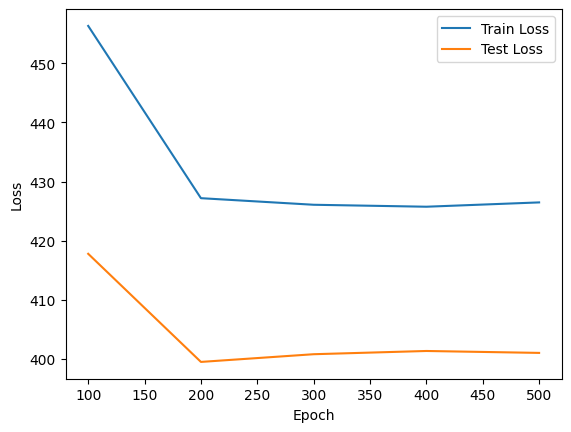

In [2]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- config ---
CSV_PATH   = "synthetic_store_sales_1000.csv"
TARGET_COL = "Sales"
EPOCHS = 500
PRINT_EVERY = 100
LR = 0.01
HIDDEN = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- load & split ---
df = pd.read_csv(CSV_PATH).dropna(subset=[TARGET_COL])
y  = df[TARGET_COL].values.astype(np.float32)
X  = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- scale 0–1 ---
scaler = MinMaxScaler().fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

print(y[0])
# --- tensors ---
Xtr = torch.tensor(X_train, dtype=torch.float32).to(device)
ytr = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)
Xte = torch.tensor(X_test, dtype=torch.float32).to(device)
yte = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)

# --- simple MLP ---
class RegressionModel(nn.Module):
    def __init__(self, in_dims, out_dims, hidden_dims):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(in_dims, hidden_dims),
          nn.ReLU(),
          nn.Linear(hidden_dims, hidden_dims),
          nn.ReLU(),
          nn.Linear(hidden_dims, out_dims)
        )

    def forward(self, x):
        return self.layers(x)

in_dims = Xtr.shape[1]
model = RegressionModel(in_dims, 1, HIDDEN).to(device)

loss_fn = nn.L1Loss()
opt  = torch.optim.Adam(model.parameters(), lr=LR)

train_loss = []
test_loss = []
epoch_count = []

# --- train loop ---
for epoch in range(1, EPOCHS+1):
    model.train()
    preds = model(Xtr)
    loss = loss_fn(preds, ytr)

    opt.zero_grad()
    loss.backward()
    opt.step()

    model.eval()
    with torch.inference_mode():
        test_preds = model(Xte)
        test_t_loss = loss_fn(test_preds, yte)
        mae = mean_absolute_error(yte.cpu().numpy(), test_preds.cpu().numpy())
        r2 = r2_score(yte.cpu().numpy(), test_preds.cpu().numpy())

        if epoch % PRINT_EVERY == 0:
            print(f"Epoch {epoch:3d} | Train MAE=${loss.item():.4f} | Test MAE=${mae:.3f} | R²={r2:.3f}")

            train_loss.append(loss.item())
            test_loss.append(test_t_loss.item())
            epoch_count.append(epoch)

# --- final eval ---
with torch.inference_mode():
    y_pred = model(Xte).cpu().numpy().ravel()
mae = mean_absolute_error(yte.cpu().numpy(), y_pred)
r2   = r2_score(yte.cpu().numpy(), y_pred)
print(f"\nFinal Test MAE: ${mae:.3f} | R²: {r2:.3f}")

plt.plot(epoch_count, train_loss, label='Train Loss')
plt.plot(epoch_count, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


realistic customer churn dataset with both a readable raw CSV (categorical columns kept) and a numeric, one-hot-encoded CSV that’s ready for your MLP.

In [ ]:
# Synthetic Customer Churn Dataset Generator (Chapter 14)
# - Saves two files:
#   1) churn_raw_5000.csv      (human-readable with categorical columns)
#   2) churn_numeric_5000.csv  (ML-ready: all numeric with one-hot encoding)
#
# Design notes:
# - Higher churn risk: month-to-month contract, electronic check, no autopay,
#   higher monthly charges, lower tenure, more support tickets, lower engagement.
# - Target: churn (1) vs active (0)
# - Intended churn rate ~ 25–35% (tunable via BASE logit)

import numpy as np
import pandas as pd

# -----------------------
# Config
# -----------------------
N = 5000
RANDOM_SEED = 42
RAW_CSV_PATH = "churn_raw_5000.csv"
NUM_CSV_PATH = "churn_numeric_5000.csv"

rng = np.random.default_rng(RANDOM_SEED)

# -----------------------
# Helper functions
# -----------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# -----------------------
# Feature synthesis
# -----------------------
# Tenure (months): skew slightly toward lower values (newer users churn more)
tenure_months = np.clip(rng.exponential(scale=18, size=N).round().astype(int) + 1, 1, 72)

# Contract type
contract_types = np.array(["Month-to-month", "One year", "Two year"])
contract_probs  = np.array([0.60, 0.25, 0.15])
contract = rng.choice(contract_types, size=N, p=contract_probs)

# Payment method
payment_methods = np.array(["Credit card", "Bank transfer", "Electronic check", "Mailed check"])
payment_probs   = np.array([0.35, 0.25, 0.25, 0.15])
payment_method  = rng.choice(payment_methods, size=N, p=payment_probs)

# Autopay: less likely for electronic check
autopay = np.where(payment_method == "Electronic check",
                   rng.random(N) < 0.30,  # only 30% autopay if e-check
                   rng.random(N) < 0.65)  # otherwise 65%

# Plan tier affects charges
plan_tiers = np.array(["Basic", "Standard", "Premium"])
tier_probs = np.array([0.45, 0.40, 0.15])
plan_tier = rng.choice(plan_tiers, size=N, p=tier_probs)

tier_price_map = {"Basic": (20, 45), "Standard": (40, 85), "Premium": (80, 130)}
monthly_charges = np.empty(N, dtype=float)
for i, t in enumerate(plan_tier):
    lo, hi = tier_price_map[t]
    monthly_charges[i] = rng.uniform(lo, hi)
# Small random surcharges/discounts
monthly_charges += rng.normal(0, 3, size=N)
monthly_charges = np.clip(monthly_charges, 15, 200).round(2)

# Engagement: logins/week (higher is better)
logins_per_week = np.clip(rng.poisson(lam=7, size=N), 0, 40)

# Support tickets in last 90 days (more tickets → more churn risk)
# Slight negative correlation with engagement
base_lambda = 0.9 + np.maximum(0, 6 - (logins_per_week / 2.5)) * 0.15
support_tickets = np.clip(rng.poisson(lam=base_lambda), 0, 15)

# Promotional flag
on_promo = rng.random(N) < 0.20

# Engagement score (0–100): blend of tenure, logins, and inverse of tickets
eng_raw = (
    (tenure_months / 72) * 0.35 +
    (np.minimum(logins_per_week, 20) / 20) * 0.45 +
    (1 - np.minimum(support_tickets, 10) / 10) * 0.20
)
engagement_score = np.clip((eng_raw * 100) + rng.normal(0, 5, size=N), 0, 100).round(1)

# -----------------------
# Churn probability model (logit)
# Higher z => higher churn probability
# Tune BASE to get ~30% churn on average.
# -----------------------
is_m2m   = (contract == "Month-to-month").astype(float)
is_echk  = (payment_method == "Electronic check").astype(float)
no_auto  = (~autopay).astype(float)

# Normalize some inputs for the logit
charges_norm = (monthly_charges - 60) / 30       # ~center near 0
tenure_norm  = (tenure_months - 24) / 18         # lower tenure -> higher churn
tickets_norm = (support_tickets - 2) / 2
eng_norm     = (engagement_score - 50) / 20      # lower engagement -> higher churn
promo_neg    = (~on_promo).astype(float)         # being on promo reduces churn slightly

# Coefficients (intuitive directions)
BASE = -0.6                      # baseline churn logit
B_CHARGES = 0.35                 # higher monthly charges -> higher churn
B_TENURE  = -0.55                # longer tenure -> lower churn
B_TICKETS = 0.50                 # more tickets -> higher churn
B_ENG     = -0.70                # higher engagement -> lower churn
B_M2M     = 0.90                 # month-to-month -> higher churn
B_NOAUTO  = 0.50                 # no autopay -> higher churn
B_ECHK    = 0.45                 # electronic check -> higher churn
B_PROMO   = -0.20                # on promo -> slightly lower churn

# Random noise to avoid too-deterministic boundary
eps = rng.normal(0, 0.4, size=N)

z = (BASE
     + B_CHARGES * charges_norm
     + B_TENURE  * tenure_norm
     + B_TICKETS * tickets_norm
     + B_ENG     * eng_norm
     + B_M2M     * is_m2m
     + B_NOAUTO  * no_auto
     + B_ECHK    * is_echk
     + B_PROMO   * (1 - promo_neg)
     + eps)

p_churn = sigmoid(z)
churn = (rng.random(N) < p_churn).astype(int)

# -----------------------
# Assemble DataFrame (raw)
# -----------------------
df_raw = pd.DataFrame({
    "tenure_months": tenure_months,
    "contract_type": contract,
    "payment_method": payment_method,
    "autopay": autopay.astype(int),
    "plan_tier": plan_tier,
    "monthly_charges": monthly_charges,
    "logins_per_week": logins_per_week,
    "support_tickets_90d": support_tickets,
    "engagement_score": engagement_score,
    "on_promo": on_promo.astype(int),
    "churn": churn
})

# -----------------------
# One-hot encode categoricals for ML-ready file
# -----------------------
categoricals = ["contract_type", "payment_method", "plan_tier"]
df_num = pd.get_dummies(df_raw, columns=categoricals, drop_first=False)

# -----------------------
# Save files
# -----------------------
df_raw.to_csv(RAW_CSV_PATH, index=False)
df_num.to_csv(NUM_CSV_PATH, index=False)

# -----------------------
# Quick report
# -----------------------
churn_rate = df_raw["churn"].mean()
print(f"Saved: {RAW_CSV_PATH} (shape={df_raw.shape})")
print(f"Saved: {NUM_CSV_PATH} (shape={df_num.shape})")
print(f"Churn rate: {churn_rate:.3f} ({churn_rate*100:.1f}%)")
print("\nRaw preview:")
print(df_raw.head())
print("\nNumeric columns preview:")
print(df_num.head())


Saved: churn_raw_5000.csv (shape=(5000, 11))
Saved: churn_numeric_5000.csv (shape=(5000, 18))
Churn rate: 0.601 (60.1%)

Raw preview:
   tenure_months   contract_type payment_method  autopay plan_tier  \
0             44  Month-to-month  Bank transfer        1     Basic   
1             43  Month-to-month    Credit card        1  Standard   
2             44        Two year    Credit card        0   Premium   
3              6  Month-to-month    Credit card        1     Basic   
4              3        One year   Mailed check        1     Basic   

   monthly_charges  logins_per_week  support_tickets_90d  engagement_score  \
0            23.47                5                    0              44.2   
1            56.63                8                    0              54.8   
2           112.46                8                    1              63.0   
3            42.26               12                    0              48.9   
4            39.42                3                    

Churn rate (train): 0.601 | pos_weight: 0.663
Epoch  10 | Train Loss=0.5361 | Test Loss=0.53 | Train Acc=60.500% | Test Acc=60.500%
Epoch  20 | Train Loss=0.5180 | Test Loss=0.51 | Train Acc=64.850% | Test Acc=66.000%
Epoch  30 | Train Loss=0.5008 | Test Loss=0.49 | Train Acc=67.300% | Test Acc=67.300%
Epoch  40 | Train Loss=0.4894 | Test Loss=0.48 | Train Acc=68.150% | Test Acc=69.500%
Epoch  50 | Train Loss=0.4835 | Test Loss=0.48 | Train Acc=68.600% | Test Acc=69.200%
Epoch  60 | Train Loss=0.4830 | Test Loss=0.48 | Train Acc=68.850% | Test Acc=69.300%
Epoch  70 | Train Loss=0.4828 | Test Loss=0.48 | Train Acc=68.625% | Test Acc=68.900%
Epoch  80 | Train Loss=0.4829 | Test Loss=0.48 | Train Acc=69.225% | Test Acc=69.100%
Epoch  90 | Train Loss=0.4830 | Test Loss=0.48 | Train Acc=68.375% | Test Acc=69.100%
Epoch 100 | Train Loss=0.4807 | Test Loss=0.48 | Train Acc=69.300% | Test Acc=69.000%

FINAL MODEL PERFORMANCE
Accuracy:  68.70%
Precision: 75.71%
Recall:    70.55%
F1-Score:  73.0

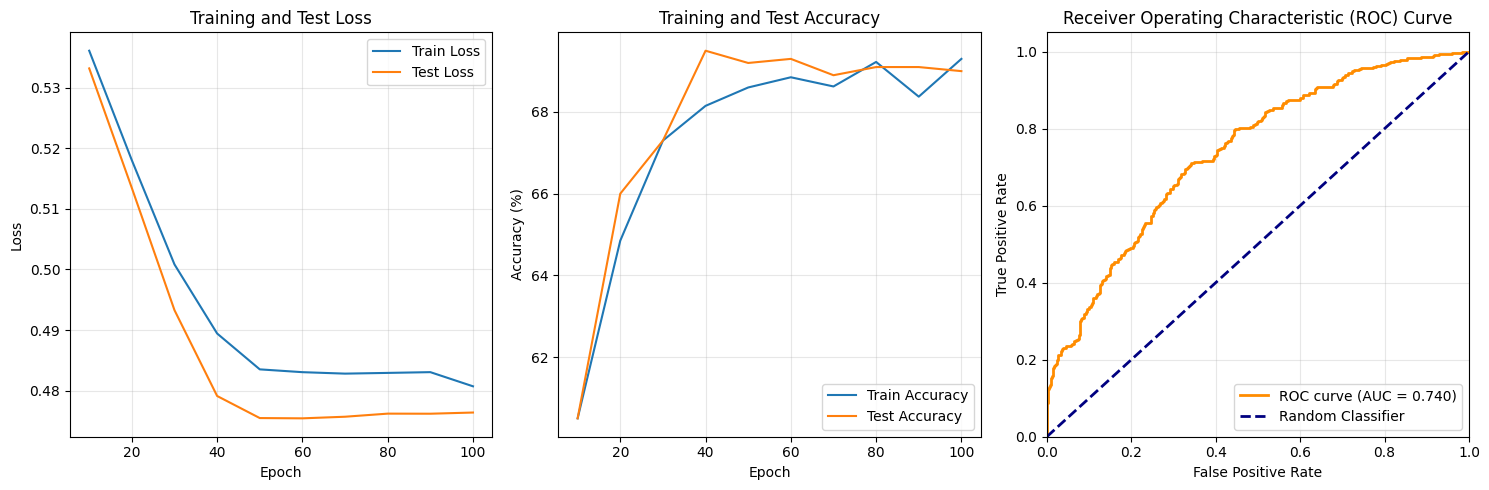

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

# --- config ---
CSV_PATH   = "churn_numeric_5000.csv"
TARGET_COL = "churn"
EPOCHS = 100
PRINT_EVERY = 10
LR = 1e-3
WEIGHT_DECAY = 1e-5
HIDDEN = 128
HIDDEN_2 = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- load ---
df = pd.read_csv(CSV_PATH).dropna(subset=[TARGET_COL])

# numeric feature matrix + target
feature_cols = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).columns.tolist()
X = df[feature_cols].astype(np.float32).values
y = df[TARGET_COL].astype(np.float32).values

# --- stratified split (preserve churn rate) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# --- scale 0–1 ---
scaler = MinMaxScaler().fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

# --- tensors ---
Xtr = torch.tensor(Xtr, dtype=torch.float32).to(device)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32).to(device)
Xte = torch.tensor(Xte, dtype=torch.float32).to(device)
yte = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32).to(device)

# --- class imbalance: pos_weight = N_neg / N_pos ---
pos_rate = float(y_train.mean())
pos_weight = torch.tensor([(1 - pos_rate) / max(pos_rate, 1e-8)], dtype=torch.float32).to(device)
print(f"Churn rate (train): {pos_rate:.3f} | pos_weight: {pos_weight.item():.3f}")


class BinaryClassificationModel(nn.Module):
    def __init__(self, in_dims, out_dims, h1, h2):
        super(BinaryClassificationModel, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(in_dims, h1),
          nn.ReLU(),

          nn.Linear(h1, h2),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(h2, out_dims)

        )

    def forward(self, x):
        return self.layers(x)

model = BinaryClassificationModel(Xtr.shape[1], 1, HIDDEN, HIDDEN_2).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt  = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
epoch_count = []

for epoch in range(1, EPOCHS+1):
    model.train()
    logits = model(Xtr)
    loss = loss_fn(logits, ytr)
    probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
    y_pred = (probs >= 0.4).astype(int)

    opt.zero_grad()
    loss.backward()
    opt.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(Xte)
        t_loss = loss_fn(test_logits, yte)
        test_probs = torch.sigmoid(test_logits).detach().cpu().numpy().ravel()
        test_y_pred = (test_probs >= 0.4).astype(int)

        if epoch % PRINT_EVERY == 0:
            train_loss.append(loss.item())
            test_loss.append(t_loss.item())
            epoch_count.append(epoch)
            train_accuracy.append(100*accuracy_score(ytr.cpu().numpy(), y_pred))
            test_accuracy.append(100*accuracy_score(yte.cpu().numpy(), test_y_pred))
            print(f"Epoch {epoch:3d} | Train Loss={loss.item():.4f} | Test Loss={t_loss.item():.2f} | Train Acc={train_accuracy[-1]:.3f}% | Test Acc={test_accuracy[-1]:.3f}%")

# Final evaluation
model.eval()
with torch.inference_mode():
    test_logits = model(Xte)
    test_probs = torch.sigmoid(test_logits).detach().cpu().numpy().ravel()
    test_y_pred = (test_probs >= 0.5).astype(int)

    # Calculate additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        yte.cpu().numpy(), test_y_pred, average='binary'
    )
    auc = roc_auc_score(yte.cpu().numpy(), test_probs)

    print("\n" + "="*50)
    print("FINAL MODEL PERFORMANCE")
    print("="*50)
    print(f"Accuracy:  {100 * accuracy_score(yte.cpu().numpy(), test_y_pred):.2f}%")
    print(f"Precision: {100 * precision:.2f}%")
    print(f"Recall:    {100 * recall:.2f}%")
    print(f"F1-Score:  {100 * f1:.2f}%")
    print(f"AUC:       {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(yte.cpu().numpy(), test_y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epoch_count, train_loss, label='Train Loss')
plt.plot(epoch_count, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(epoch_count, train_accuracy, label='Train Accuracy')
plt.plot(epoch_count, test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC Curve
plt.subplot(1, 3, 3)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(yte.cpu().numpy(), test_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Chapter 15 — Case Study: Multi-Class Classification – Predicting Customer Segments
